In [1]:
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import os

# Load training data (for splitting to get test set)
out = np.load('../training-val-test-data.npz')
th_train = out['th']
u_train = out['u']

# Create the same splitting again to isolate test set
def create_IO_data(u, y, na, nb):
    X, Y = [], []
    for k in range(max(na, nb), len(y)):
        X.append(np.concatenate([u[k-nb:k], y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)

# Define model class
class Network(nn.Module):
    def __init__(self, n_hidden_nodes=40, n_in=20):
        super(Network, self).__init__()
        self.layer1 = nn.Linear(n_in, n_hidden_nodes).double()
        self.layer2 = nn.Linear(n_hidden_nodes, n_hidden_nodes).double()
        self.layer3 = nn.Linear(n_hidden_nodes, 1).double()

    def forward(self, u):
        x1 = torch.nn.functional.leaky_relu(self.layer1(u))
        x2 = torch.nn.functional.leaky_relu(self.layer2(x1))
        y = self.layer3(x2)[:, 0]
        return y

# Evaluation metrics
def print_metrics(pred, true, name="Set"):
    rms = np.mean((pred - true)**2)**0.5
    print(f'{name} RMS: {rms:.5f} radians')
    print(f'{name} RMS: {rms / (2*np.pi) * 360:.2f} degrees')
    print(f'{name} NRMS: {rms / np.std(true) * 100:.2f} %')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

rms_matrix = np.full((16, 16), np.nan)  # 16x16 matrix of RMS values

# Sweep through saved models and evaluate
for na in range(16):
    for nb in range(16):
        model_path = f"models/model_na{na}_nb{nb}.pt"
        if not os.path.exists(model_path):
            print(f"Model file not found for na={na}, nb={nb}")
            continue

        # Recreate input-output data
        X, Y = create_IO_data(u_train, th_train, na, nb)
        Xtemp, Xtest_final, Ytemp, Ytest_final = train_test_split(X, Y, test_size=0.15, random_state=42)
        Xtrain_final, Xval, Ytrain_final, Yval = train_test_split(Xtemp, Ytemp, test_size=0.1765, random_state=42)

        # Convert to tensors
        Xtest_tensor = torch.tensor(Xtest_final).to(device).double()
        Ytest_tensor = torch.tensor(Ytest_final).to(device).double()

        # Load model
        model = Network(n_hidden_nodes=40, n_in=na+nb).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        # Evaluate
        with torch.no_grad():
            test_pred = model(Xtest_tensor).cpu().numpy()
        Ytest_np = Ytest_tensor.cpu().numpy()

        print(f"\n=== Evaluation for model_na{na}_nb{nb}.pt ===")
        print_metrics(test_pred, Ytest_np, "Test")

        rms = np.mean((test_pred - Ytest_np)**2)**0.5
        rms_matrix[na, nb] = rms
        # print(f"Model (na={na}, nb={nb}) RMS: {rms:.5f} radians")


Using device: cuda


c:\Users\xskap\miniconda3\envs\ml4sc\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")



=== Evaluation for model_na0_nb0.pt ===
Test RMS: 0.47705 radians
Test RMS: 27.33 degrees
Test NRMS: 100.00 %

=== Evaluation for model_na0_nb1.pt ===
Test RMS: 0.48349 radians
Test RMS: 27.70 degrees
Test NRMS: 99.42 %

=== Evaluation for model_na0_nb2.pt ===
Test RMS: 0.42884 radians
Test RMS: 24.57 degrees
Test NRMS: 88.61 %

=== Evaluation for model_na0_nb3.pt ===
Test RMS: 0.35295 radians
Test RMS: 20.22 degrees
Test NRMS: 72.49 %

=== Evaluation for model_na0_nb4.pt ===
Test RMS: 0.34860 radians
Test RMS: 19.97 degrees
Test NRMS: 71.17 %

=== Evaluation for model_na0_nb5.pt ===
Test RMS: 0.34563 radians
Test RMS: 19.80 degrees
Test NRMS: 70.92 %

=== Evaluation for model_na0_nb6.pt ===
Test RMS: 0.34814 radians
Test RMS: 19.95 degrees
Test NRMS: 71.89 %

=== Evaluation for model_na0_nb7.pt ===
Test RMS: 0.34576 radians
Test RMS: 19.81 degrees
Test NRMS: 72.12 %

=== Evaluation for model_na0_nb8.pt ===
Test RMS: 0.33084 radians
Test RMS: 18.96 degrees
Test NRMS: 68.83 %

=== Eval

In [2]:
rms_matrix100 = rms_matrix * 100
rms_matrix100_4to15 = rms_matrix100[3:]
rms_matrix100_4to15_2to15 = rms_matrix100_4to15[3:][2:]
rms_matrix1000 = rms_matrix * 1000

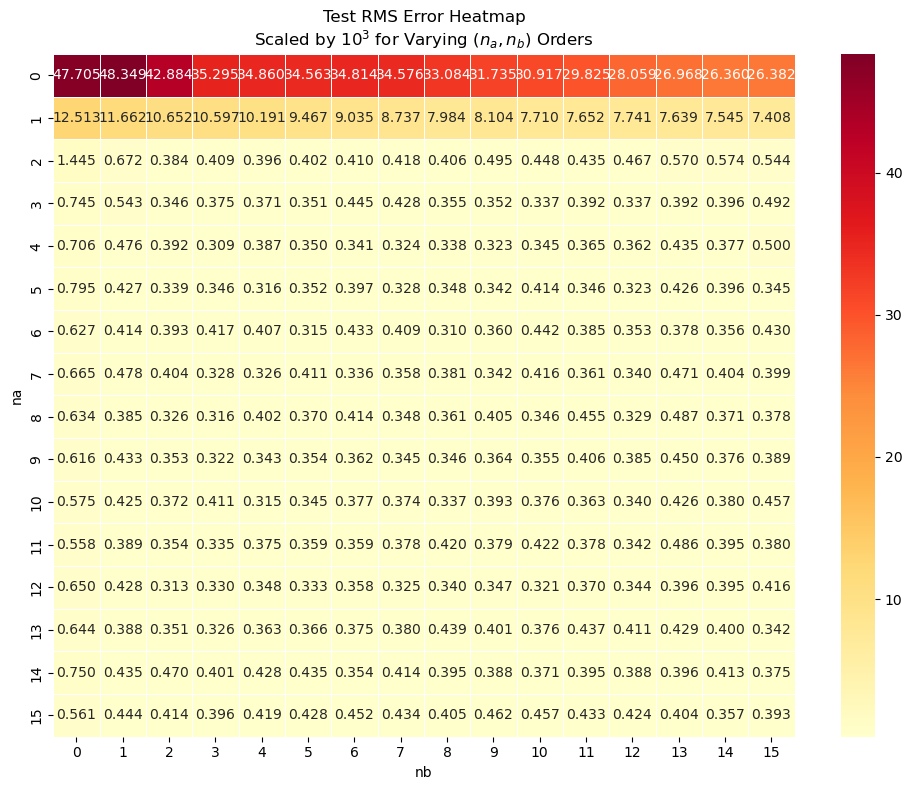

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    rms_matrix100,
    annot=True,
    fmt=".3f",
    cmap="YlOrRd",  # Yellow to red
    linewidths=0.5,
    xticklabels=range(16),
    yticklabels=range(16)
)
ax.set_xlabel("nb")
ax.set_ylabel("na")
ax.set_title("Test RMS Error Heatmap\nScaled by $10^3$ for Varying $(n_a, n_b)$ Orders")
plt.tight_layout()
plt.show()


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix_regression(y_true, y_pred, n_bins=20, title="Confusion Matrix (Binned)"):
    import matplotlib.colors as mcolors

    # Discretize values into bins
    bins = np.linspace(min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max()), n_bins)
    true_binned = np.digitize(y_true, bins)
    pred_binned = np.digitize(y_pred, bins)

    # Compute confusion matrix
    cm = confusion_matrix(true_binned, pred_binned, labels=np.arange(1, n_bins + 1))

    # Plotting with log scale
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        norm=mcolors.LogNorm(vmin=1, clip=True),  # log scale
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=False,
        yticklabels=False
    )
    plt.title(title)
    plt.xlabel("na")
    plt.ylabel("nb")
    plt.tight_layout()
    plt.show()



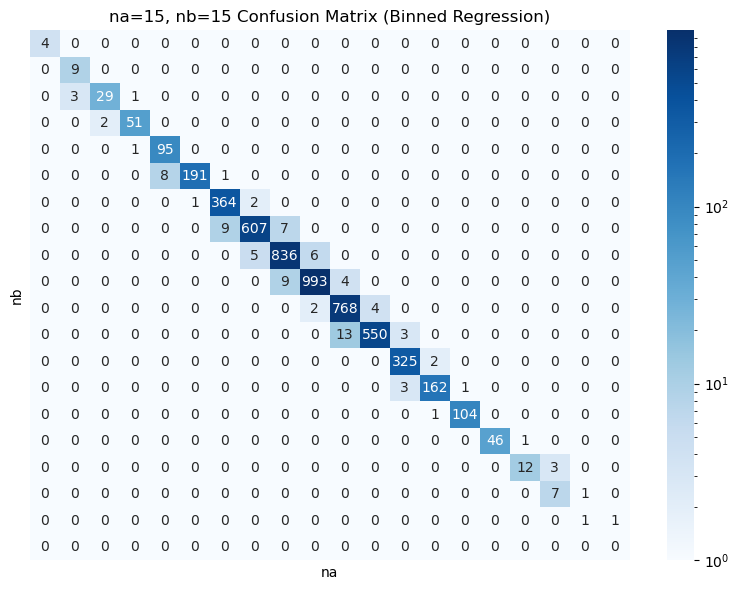

In [5]:
plot_confusion_matrix_regression(Ytest_np, test_pred,
                                         n_bins=20,
                                         title=f"na={na}, nb={nb} Confusion Matrix (Binned Regression)")

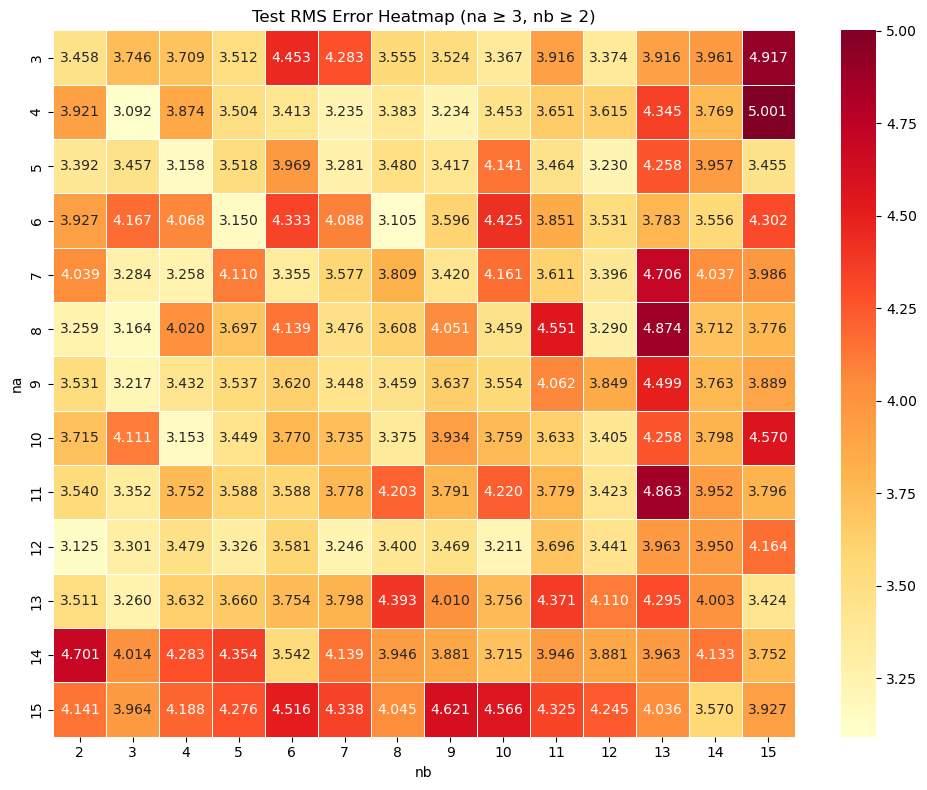

In [6]:
# Remove first 3 rows (na 0,1,2) and first 2 columns (nb 0,1)
rms_cropped = rms_matrix1000[3:, 2:]

na_labels = list(range(3, 16))
nb_labels = list(range(2, 16))

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    rms_cropped,
    annot=True,
    fmt=".3f",
    cmap="YlOrRd",
    linewidths=0.5,
    xticklabels=nb_labels,
    yticklabels=na_labels
)

ax.set_xlabel("nb")
ax.set_ylabel("na")
ax.set_title("Test RMS Error Heatmap (na ≥ 3, nb ≥ 2)")
plt.tight_layout()
plt.show()

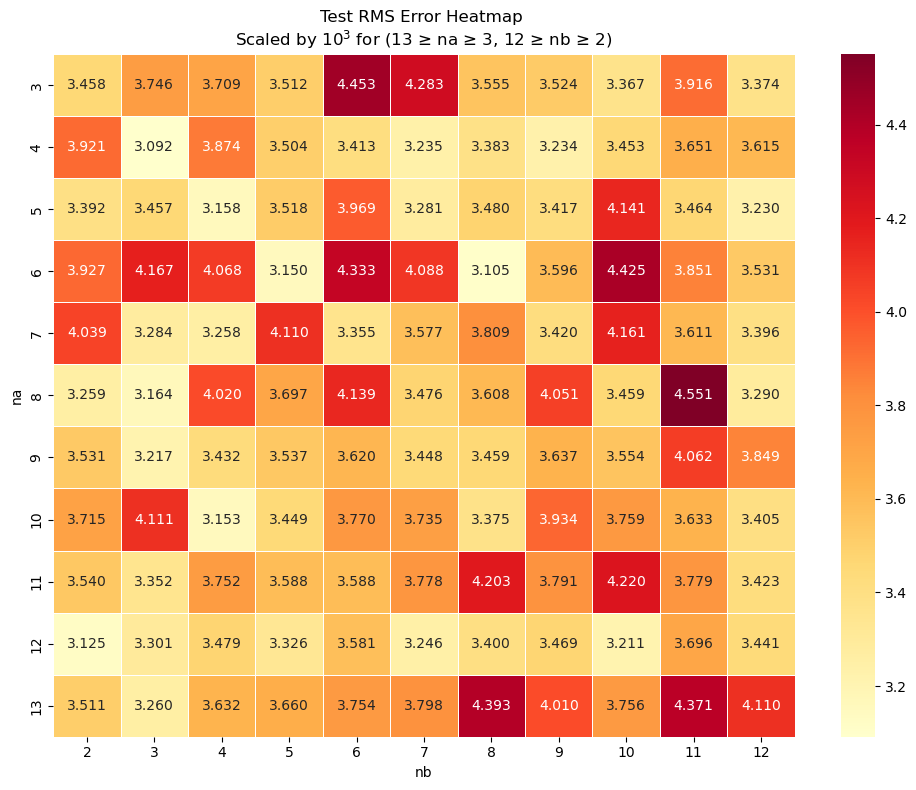

In [10]:
rms_cropped_2 = rms_matrix1000[3:-2, 2:-3]

na_labels = list(range(3, 14))
nb_labels = list(range(2, 13))

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    rms_cropped_2,
    annot=True,
    fmt=".3f",
    cmap="YlOrRd",
    linewidths=0.5,
    xticklabels=nb_labels,
    yticklabels=na_labels
)

ax.set_xlabel("nb")
ax.set_ylabel("na")
ax.set_title("Test RMS Error Heatmap \nScaled by $10^3$ for (13 ≥ na ≥ 3, 12 ≥ nb ≥ 2)")
plt.tight_layout()
plt.show()